# Read in Data

In [482]:
# ================================================================================
# Splitting training and test sets
# ================================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv('WAGE2_2025_abridged.csv')

state= (540491669 + 540712391 + 540575497 + 540750669 + 540744934)   # replace this number with the sum of the student IDs for the members of your group

train = data.sample(frac=0.8, random_state=state)
test = data[data.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [483]:
train.head()

wage  hours   IQ  KWW  educ  exper  tenure  age  married  black  south  \
0  1160     40   92   32    12      8       8   31        1      0      0   
1   722     55  113   36    16      8       1   38        0      0      1   
2  1160     40   84   35    12     17       2   38        1      0      0   
3  1000     50  104   36    16     11       8   30        1      0      0   
4   978     48  104   36    12     19      15   36        1      0      0   

   urban  sibs  brthord  meduc  feduc     lwage  
0      0     4      1.0   12.0   11.0  7.056175  
1      1     1      2.0    8.0    NaN  6.582025  
2      0     4      2.0   16.0   12.0  7.056175  
3      1     1      1.0   12.0   11.0  6.907755  
4      1     5      6.0    6.0    NaN  6.885510

In [484]:
train.isnull().sum()

wage         0
hours        0
IQ           0
KWW          0
educ         0
exper        0
tenure       0
age          0
married      0
black        0
south        0
urban        0
sibs         0
brthord     62
meduc       56
feduc      152
lwage        0
dtype: int64

### Forward Selected Data ###

In [485]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [486]:
df = train[['wage', 'educ', 'exper', 'hours', 'IQ', 'KWW', 'tenure', 'age', 'married', 'black', 'south', 'urban', 'sibs', 'meduc', 'feduc']]

In [487]:
model = forward_selected(df, 'wage')

adding educ increases adj_r2 from 0.000000 to 0.095299
adding KWW increases adj_r2 from 0.095299 to 0.138050
adding urban increases adj_r2 from 0.138050 to 0.161508
adding exper increases adj_r2 from 0.161508 to 0.181577
adding married increases adj_r2 from 0.181577 to 0.198835
adding IQ increases adj_r2 from 0.198835 to 0.215564
adding black increases adj_r2 from 0.215564 to 0.222994
adding tenure increases adj_r2 from 0.222994 to 0.228216
adding hours increases adj_r2 from 0.228216 to 0.230359
adding age increases adj_r2 from 0.230359 to 0.230768
adding south increases adj_r2 from 0.230768 to 0.230818
final model is wage ~ educ + KWW + urban + exper + married + IQ + black + tenure + hours + age + south + 1, with adj_r2 of 0.230818


# **Task 1**

### Numerical Summaries ###

In [488]:
numerical = train[['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age', 'sibs', 'meduc', 'feduc', 'lwage']]
numerical.describe().round(3)

wage    hours       IQ      KWW     educ    exper   tenure  \
count   733.000  733.000  733.000  733.000  733.000  733.000  733.000   
mean    962.921   44.082  101.854   35.801   13.501   11.487    7.235   
std     402.656    7.134   14.500    7.656    2.182    4.456    5.089   
min     200.000   20.000   54.000   12.000    9.000    1.000    0.000   
25%     675.000   40.000   93.000   31.000   12.000    8.000    3.000   
50%     910.000   40.000  103.000   37.000   12.000   11.000    7.000   
75%    1186.000   48.000  112.000   41.000   16.000   15.000   11.000   
max    3078.000   80.000  145.000   56.000   18.000   23.000   22.000   

           age     sibs    meduc    feduc    lwage  
count  733.000  733.000  677.000  581.000  733.000  
mean    33.034    2.898   10.703   10.176    6.787  
std      3.122    2.199    2.843    3.317    0.412  
min     28.000    0.000    0.000    0.000    5.298  
25%     30.000    1.000    8.000    8.000    6.515  
50%     33.000    2.000   12.000   10.000    6.813  
75%     36.000    4.000   12.000   12.000    7.078  
max     38.000   14.000   18.000   18.000    8.032

### Categorical summaries ###

In [489]:
tab=pd.crosstab(data['married'], columns="count");tab

col_0    count
married       
0           98
1          818

In [490]:
tab=pd.crosstab(data['black'], columns="count");tab

col_0  count
black       
0        807
1        109

In [491]:
tab=pd.crosstab(data['south'], columns="count");tab

col_0  count
south       
0        608
1        308

In [492]:
tab=pd.crosstab(data['urban'], columns="count");tab

col_0  count
urban       
0        256
1        660

In [493]:
tab=pd.crosstab(data['brthord'], columns="count");tab

col_0    count
brthord       
1.0        339
2.0        237
3.0        125
4.0         56
5.0         33
6.0         28
7.0          8
8.0          5
9.0          2
10.0         3

### Visuals ###

<Axes: xlabel='wage'>

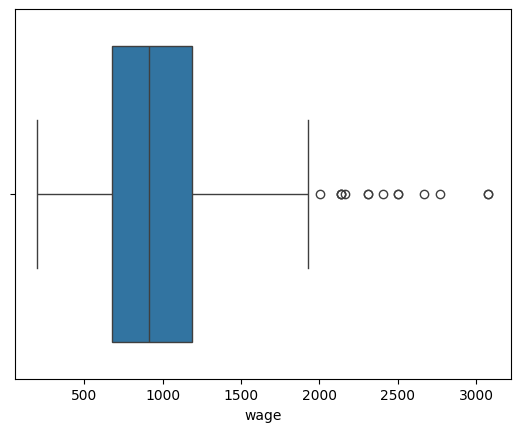

In [494]:
sns.boxplot(x=train['wage'])

<Axes: xlabel='married', ylabel='wage'>

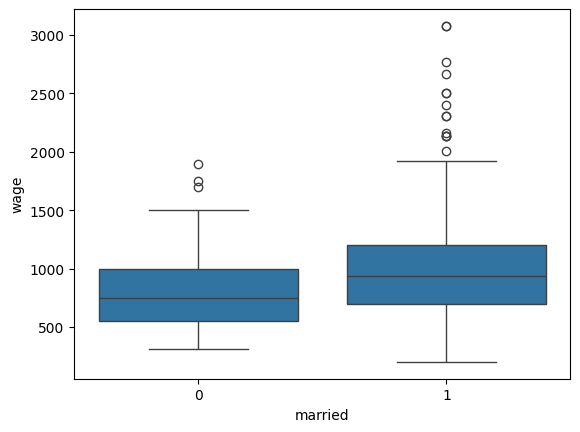

In [495]:
sns.boxplot(x='married', y='wage', data=train)

<Axes: xlabel='black', ylabel='wage'>

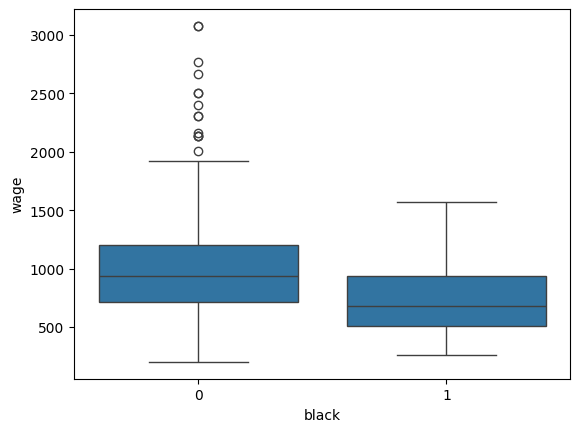

In [496]:
sns.boxplot(x='black', y='wage', data=train)

In [497]:
print(data.groupby('south')['wage'].mean())

south
0    1006.052632
1     868.993506
Name: wage, dtype: float64


In [498]:
print(data.groupby('urban')['wage'].mean())

urban
0     832.332031
1    1009.474242
Name: wage, dtype: float64


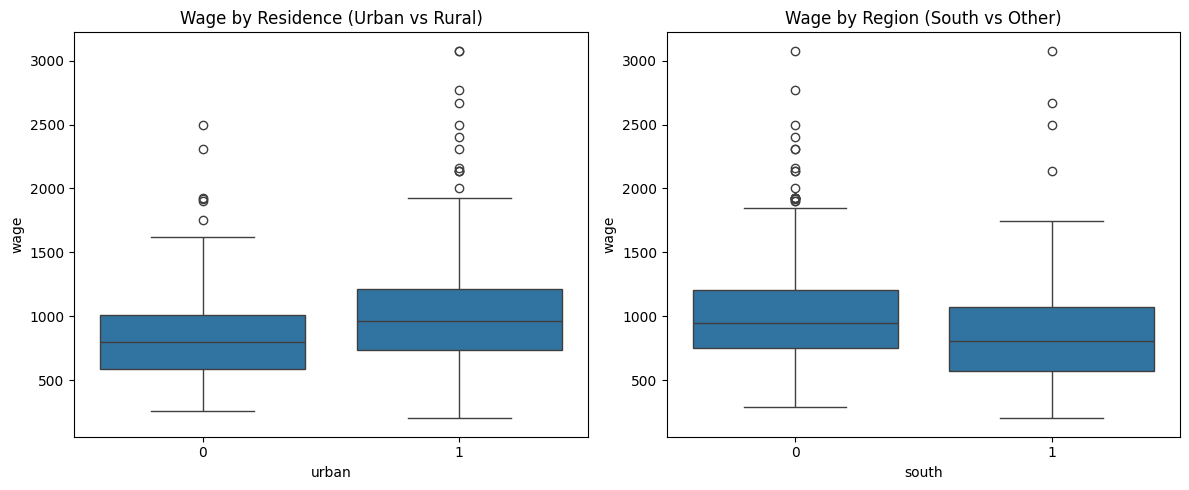

In [499]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Boxplot 1: Urban vs Rural
sns.boxplot(x='urban', y='wage', data=train, ax=axes[0])
axes[0].set_title("Wage by Residence (Urban vs Rural)")

# Boxplot 2: South vs Other
sns.boxplot(x='south', y='wage', data=train, ax=axes[1])
axes[1].set_title("Wage by Region (South vs Other)")

plt.tight_layout()
plt.savefig('region wage.png')
plt.show()

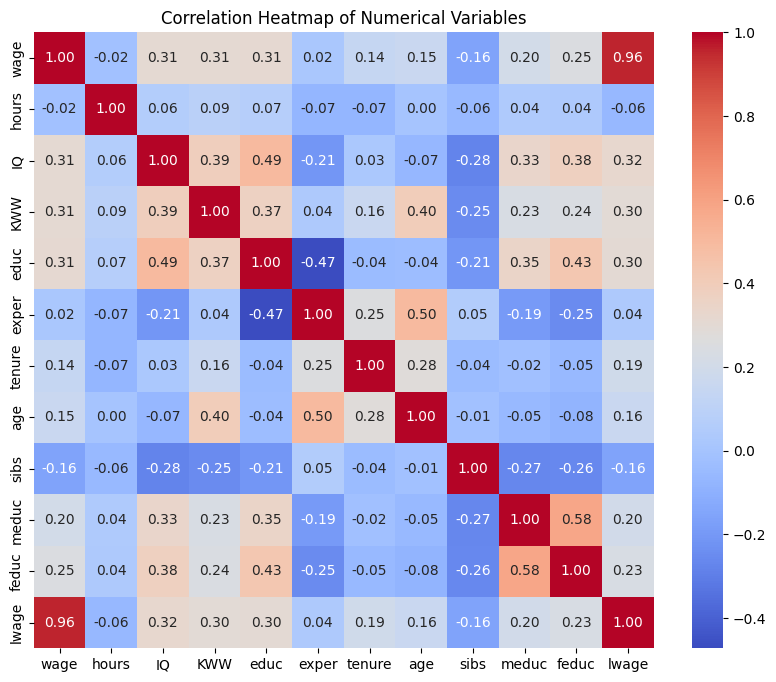

In [500]:
corr_matrix = numerical.corr()

plt.figure(figsize=(10, 8))  # Optional: adjust size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.savefig('heatmap all var.png')
plt.show()

### Comparing education in sub groups ###

In [501]:
print(data.groupby('south')['educ'].mean())

south
0    13.648026
1    13.185065
Name: educ, dtype: float64


In [502]:
print(data.groupby('urban')['educ'].mean())

urban
0    13.238281
1    13.590909
Name: educ, dtype: float64


In [503]:
print(data.groupby('black')['educ'].mean())

black
0    13.629492
1    12.477064
Name: educ, dtype: float64


In [504]:
print(data.groupby('married')['educ'].mean())

married
0    13.846939
1    13.449878
Name: educ, dtype: float64


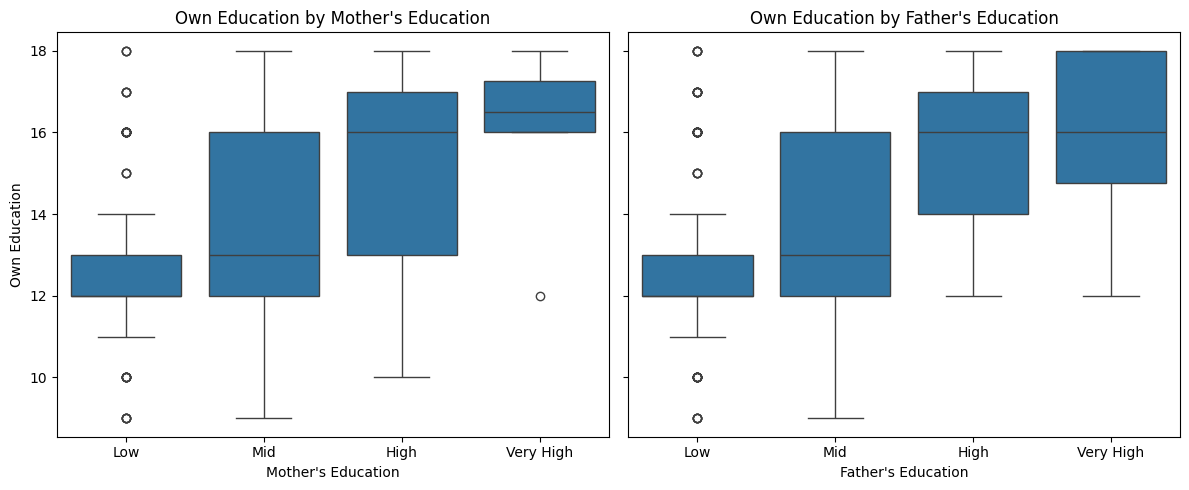

In [505]:
# Create bins for mother and father education
train['meduc_bin'] = pd.cut(train['meduc'], bins=[0, 8, 12, 16, 20], labels=['Low', 'Mid', 'High', 'Very High'])
train['feduc_bin'] = pd.cut(train['feduc'], bins=[0, 8, 12, 16, 20], labels=['Low', 'Mid', 'High', 'Very High'])

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Mother's education
sns.boxplot(x='meduc_bin', y='educ', data=train, ax=axes[0])
axes[0].set_title("Own Education by Mother's Education")
axes[0].set_xlabel("Mother's Education")
axes[0].set_ylabel("Own Education")

# Father's education
sns.boxplot(x='feduc_bin', y='educ', data=train, ax=axes[1])
axes[1].set_title("Own Education by Father's Education")
axes[1].set_xlabel("Father's Education")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig('parental education vs own education.png')
plt.show()

# **Task 2**

### MLR of education and experience on wage

In [506]:
t2_model = smf.ols('wage ~ educ + exper', data=train)
t2_reg = t2_model.fit()
t2_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     55.84
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.72e-23
Time:                        22:18:32   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    122.739     -2.353      0.019    -529.742     -47.814
educ          76.1294      7.216     10.550      0.000      61.963      90.296
exper         19.4915      3.534      5.516      0.000      12.554      26.429
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [507]:
#Extracting Fitted Values and Residuals from the Regression Model
t2_fit = t2_reg.fittedvalues
t2_resid = t2_reg.resid

In [508]:
t2_reg.mse_resid**0.5

np.float64(375.5059302119657)

In [509]:
t2_reg_rob = t2_model.fit(cov_type = 'HC0')
t2_reg_rob.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     47.42
Date:                Thu, 22 May 2025   Prob (F-statistic):           4.36e-20
Time:                        22:18:32   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    128.375     -2.249      0.024    -540.388     -37.168
educ          76.1294      7.848      9.700      0.000      60.747      91.512
exper         19.4915      3.479      5.603      0.000      12.673      26.310
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

After correcting for potential heteroskedasticity using HC1 robust standard errors, the model’s coefficients remained statistically significant, suggesting that the key relationships are robust. However, the increase in standard errors and the lower F-statistic indicate that inference under standard OLS may have understated uncertainty.

In [510]:
t2_slr_educ_model = smf.ols('wage ~ educ', data=train).fit()
t2_slr_educ_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     78.11
Date:                Thu, 22 May 2025   Prob (F-statistic):           7.21e-18
Time:                        22:18:32   Log-Likelihood:                -5399.0
No. Observations:                 733   AIC:                         1.080e+04
Df Residuals:                     731   BIC:                         1.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    188.8699     88.719      2.129      0.034      14.695     363.045
educ          57.3342      6.487      8.838      0.000      44.598      70.070
==============================================================================
Omnibus:                      179.416   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.454
Skew:                           1.179   Prob(JB):                    2.95e-120
Kurtosis:                       6.531   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [511]:
t2_slr_exper_model = smf.ols('wage ~ exper', data=train).fit()
t2_slr_exper_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3188
Date:                Thu, 22 May 2025   Prob (F-statistic):              0.572
Time:                        22:18:32   Log-Likelihood:                -5436.0
No. Observations:                 733   AIC:                         1.088e+04
Df Residuals:                     731   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    941.2470     41.168     22.863      0.000     860.425    1022.069
exper          1.8868      3.342      0.565      0.572      -4.673       8.447
==============================================================================
Omnibus:                      186.803   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.904
Skew:                           1.275   Prob(JB):                    1.89e-111
Kurtosis:                       6.193   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### LSA 1: Linearity

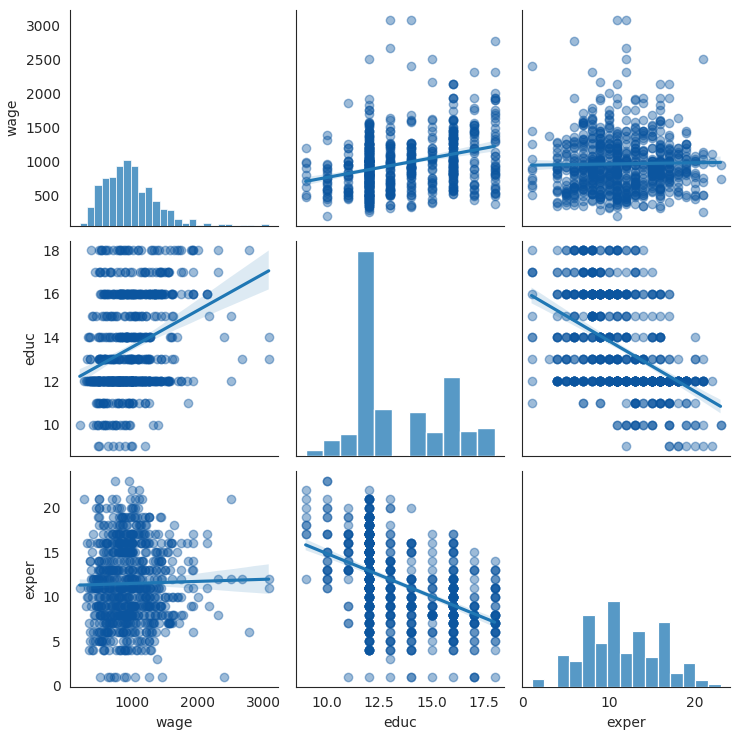

In [512]:

variables=['wage', 'educ', 'exper']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg',
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})
plt.tight_layout()

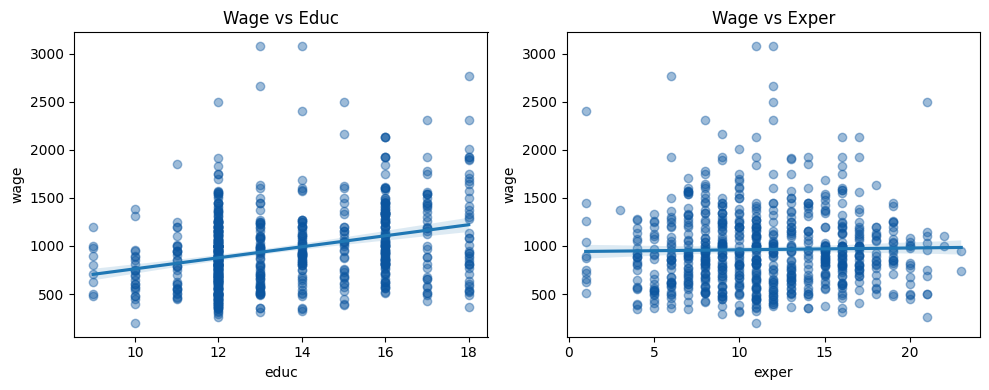

In [513]:
plt.figure(figsize=(10, 4))

# Top-middle: wage vs educ
plt.subplot(1, 2, 1)
sns.regplot(x='educ', y='wage', data=train,
            scatter_kws={'color': sns.color_palette('Blues')[-1], 'alpha': 0.4})
plt.title('Wage vs Educ')

# Top-right: wage vs exper
plt.subplot(1, 2, 2)
sns.regplot(x='exper', y='wage', data=train,
            scatter_kws={'color': sns.color_palette('Blues')[-1], 'alpha': 0.4})
plt.title('Wage vs Exper')

plt.tight_layout()
plt.show()

### LSA 2: Exogeneity

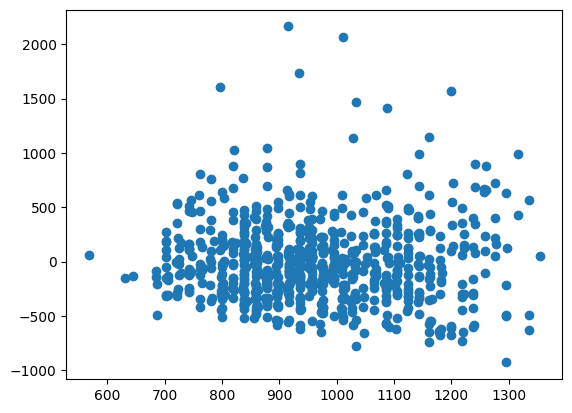

In [514]:
plt.scatter(t2_fit, t2_resid)
plt.show()

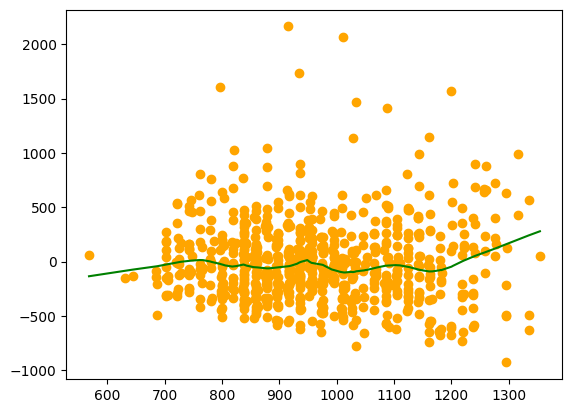

In [515]:
lowess = sm.nonparametric.lowess
plt.scatter(t2_fit, t2_resid, color='orange')
t2_z = lowess(t2_resid, t2_fit, frac=1./5)
plt.plot(t2_z[:,0],t2_z[:,1],'green')
plt.show()

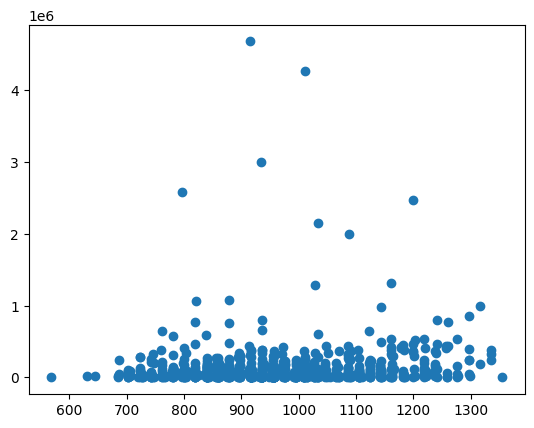

In [516]:
#Squared Residuals for MLR
t2_resid2=t2_reg.resid**2
plt.scatter(t2_fit, t2_resid2)
plt.show()

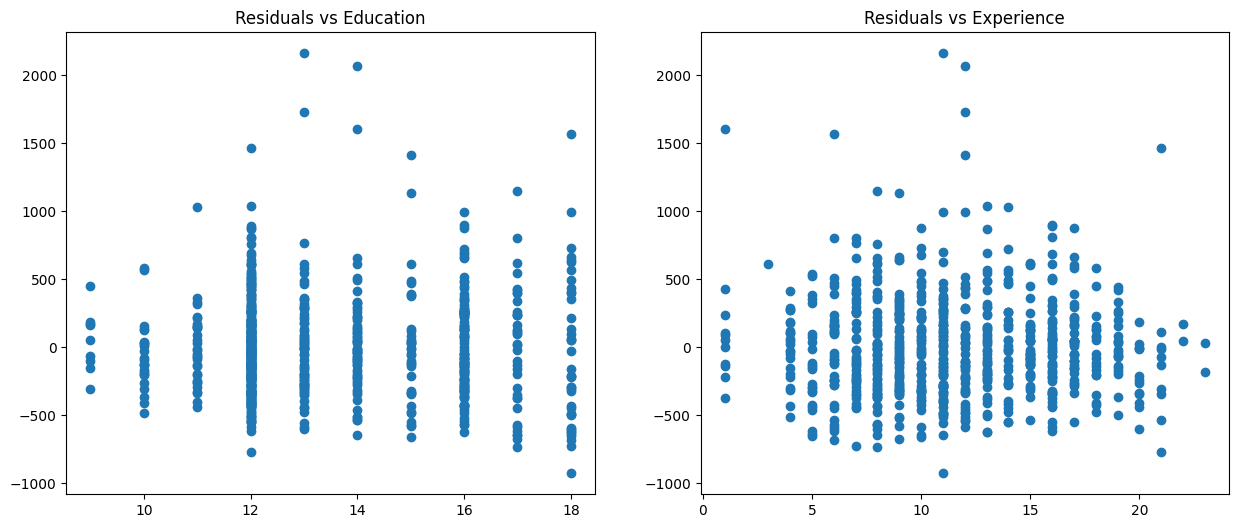

In [517]:
#Residuals against predictors
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(train['educ'], t2_resid)
ax1.set_title("Residuals vs Education")

ax2.scatter(train['exper'], t2_resid)
ax2.set_title("Residuals vs Experience")

plt.show()

### LSA 3: Data is IID

The data represent a cross-sectional survey of income earners, with each row corresponding to a distinct individual. Given that the observations are drawn independently from a population and reflect individual-level attributes, we assume the data satisfy LSA 3, the observations are independent and identically distributed.

### LSA 4: All 4th Moments Exist

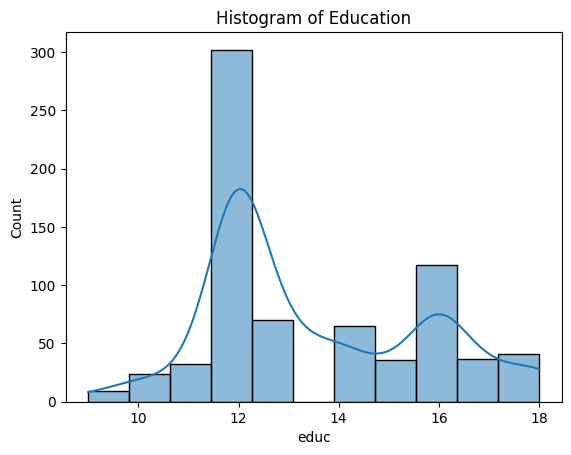

In [518]:
sns.histplot(train['educ'], kde=True)
plt.title("Histogram of Education")
plt.savefig('hist educ.png')
plt.show()

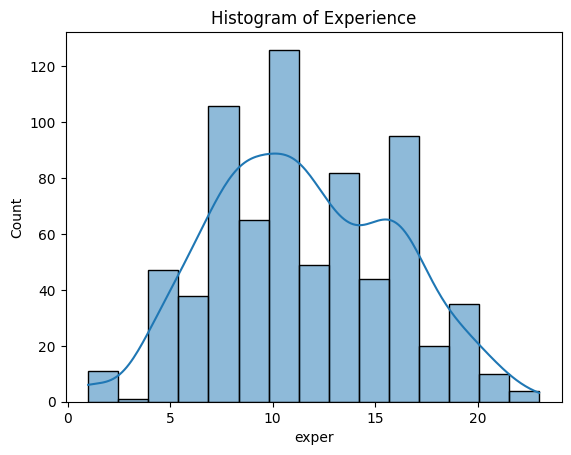

In [519]:
sns.histplot(train['exper'], kde=True)
plt.title("Histogram of Experience")
plt.savefig('hist exper.png')
plt.show()

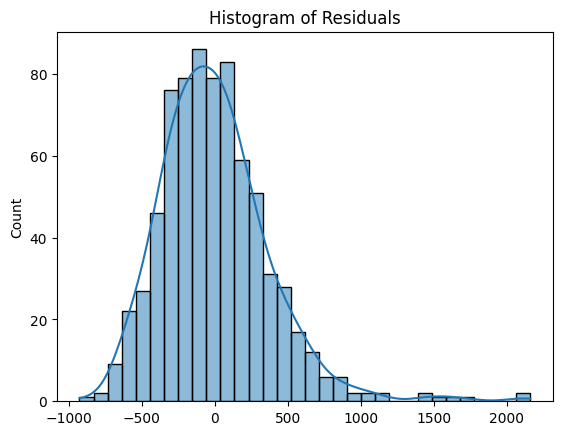

In [520]:
sns.histplot(t2_resid, kde=True)
plt.title("Histogram of Residuals")
plt.show()

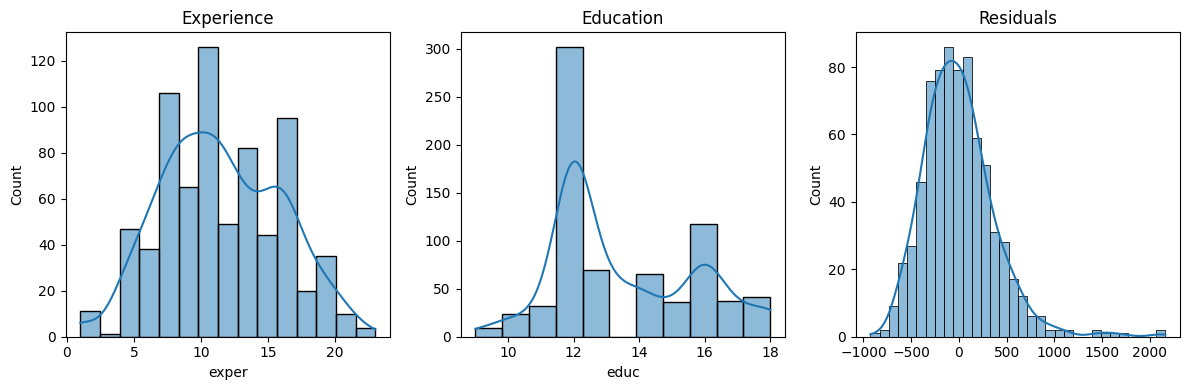

In [521]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

sns.histplot(train['exper'], kde=True, ax=axes[0])
axes[0].set_title("Experience")

sns.histplot(train['educ'], kde=True, ax=axes[1])
axes[1].set_title("Education")

sns.histplot(t2_resid, kde=True, ax=axes[2])  
axes[2].set_title("Residuals")

plt.tight_layout()
plt.savefig("lsa4_histograms.png", dpi=300, bbox_inches='tight')

### LSA 5: No Perfect Collinearity

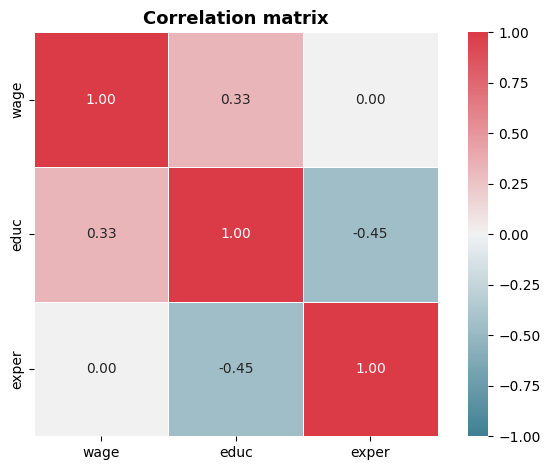

In [522]:
fig, ax = plt.subplots()
variables = ['wage', 'educ', 'exper']
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data[variables].corr(), vmax=1, vmin=-1, center=0, square=True, linewidths=0.5, annot=True, fmt='.2f', ax=ax, cmap=cmap)

ax.set_title('Correlation matrix', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('correlation matrix.png')
plt.show()

### LSA 6: Homoskedacity

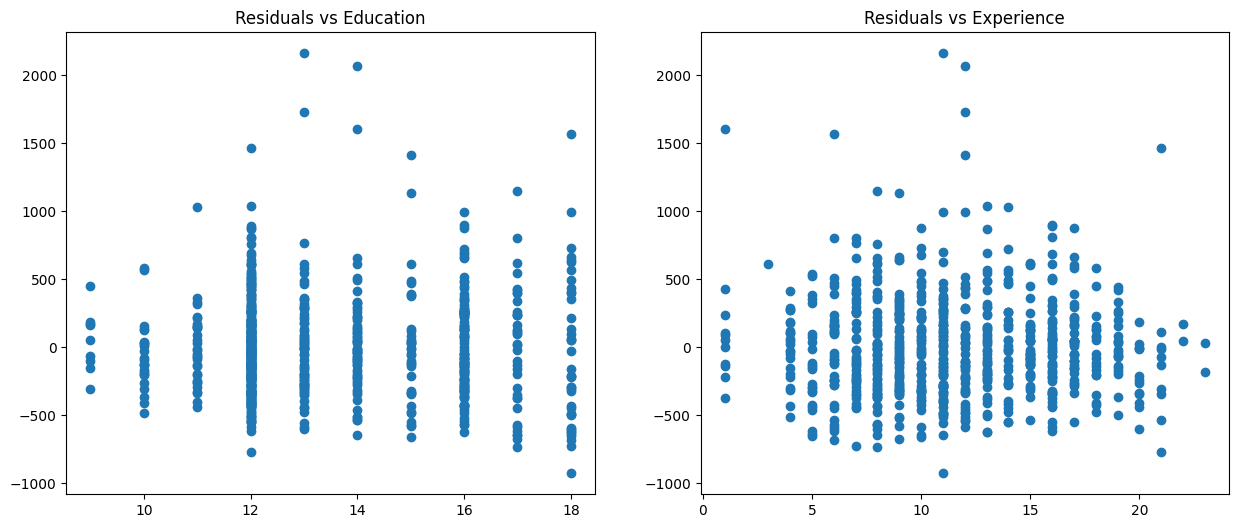

In [523]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(train['educ'], t2_resid)
ax1.set_title('Residuals vs Education')
ax2.scatter(train['exper'], t2_resid)
ax2.set_title('Residuals vs Experience')
plt.savefig('homoskedacity.png')
plt.show()

# **Task 3**

### Relationship between Wage and Education, and Wage and Experience ###

In [524]:
t3_slr_educ_model = smf.ols('wage ~ educ', data=train).fit()
t3_slr_educ_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     78.11
Date:                Thu, 22 May 2025   Prob (F-statistic):           7.21e-18
Time:                        22:18:38   Log-Likelihood:                -5399.0
No. Observations:                 733   AIC:                         1.080e+04
Df Residuals:                     731   BIC:                         1.081e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    188.8699     88.719      2.129      0.034      14.695     363.045
educ          57.3342      6.487      8.838      0.000      44.598      70.070
==============================================================================
Omnibus:                      179.416   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              550.454
Skew:                           1.179   Prob(JB):                    2.95e-120
Kurtosis:                       6.531   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [525]:
t2_slr_exper_model = smf.ols('wage ~ exper', data=train).fit()
t2_slr_exper_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3188
Date:                Thu, 22 May 2025   Prob (F-statistic):              0.572
Time:                        22:18:38   Log-Likelihood:                -5436.0
No. Observations:                 733   AIC:                         1.088e+04
Df Residuals:                     731   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    941.2470     41.168     22.863      0.000     860.425    1022.069
exper          1.8868      3.342      0.565      0.572      -4.673       8.447
==============================================================================
Omnibus:                      186.803   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              509.904
Skew:                           1.275   Prob(JB):                    1.89e-111
Kurtosis:                       6.193   Cond. No.                         34.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **Task 4**

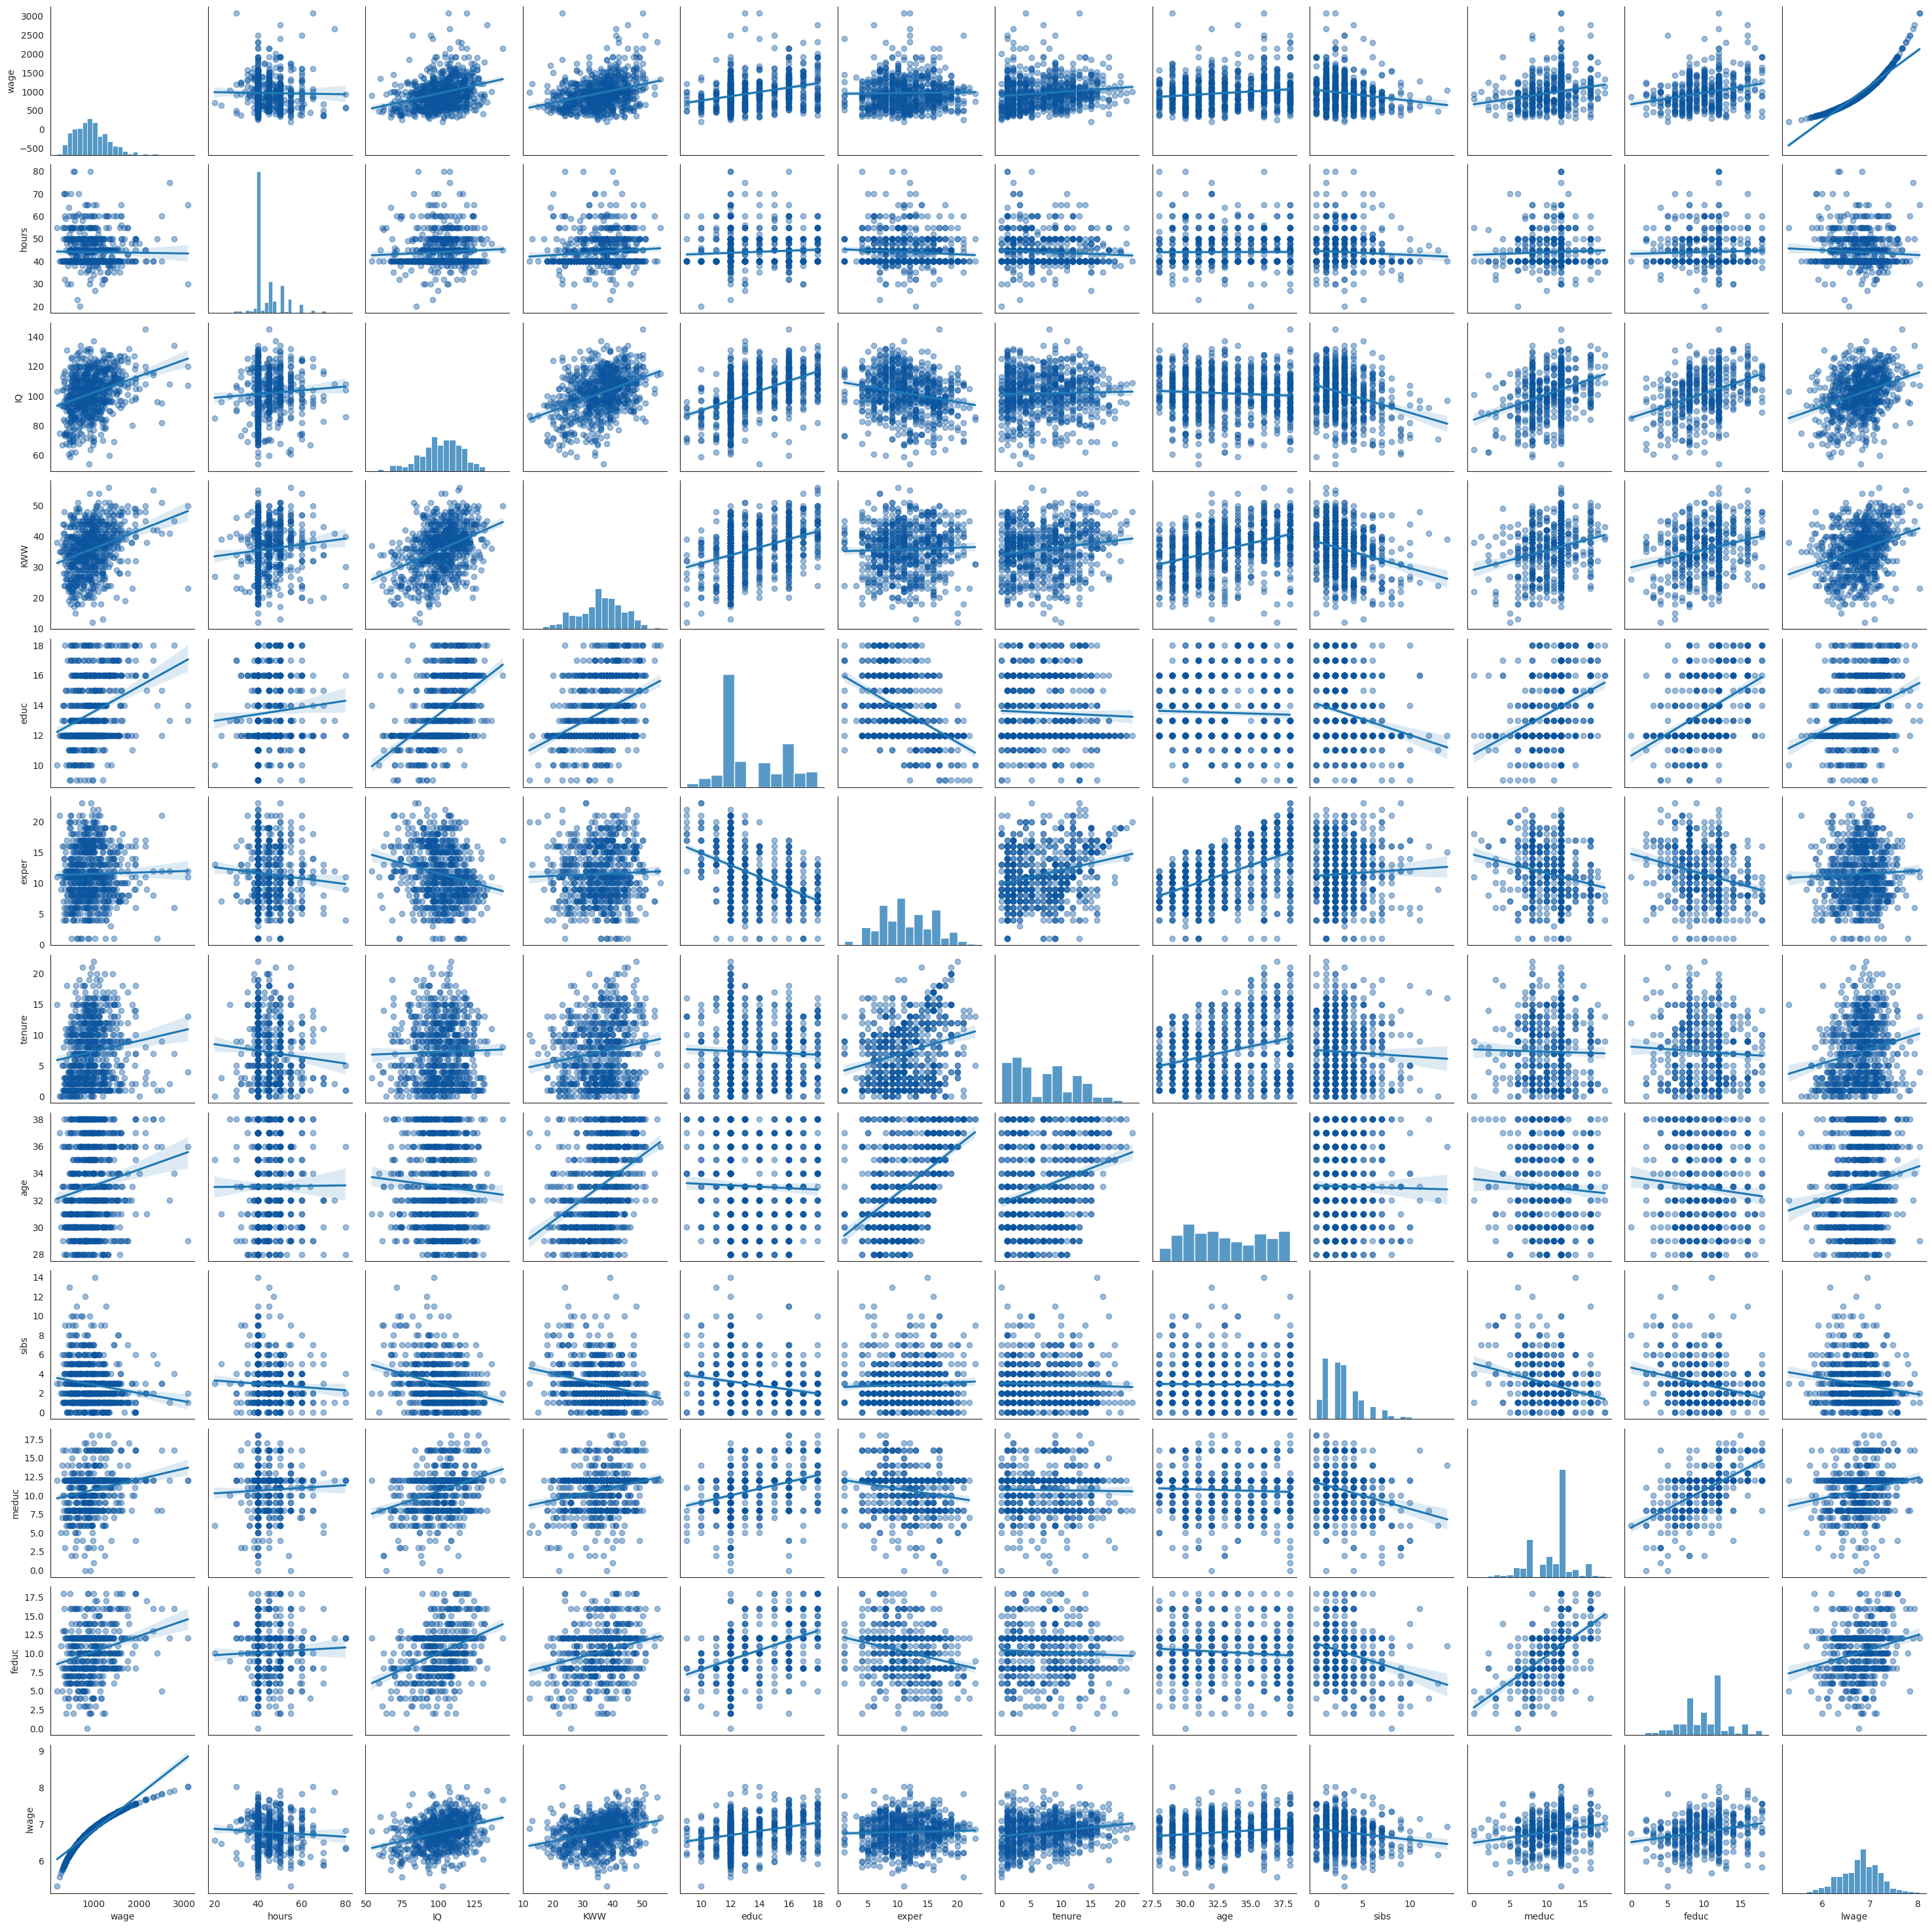

In [526]:
variables=['wage', 'hours', 'IQ', 'KWW', 'educ', 'exper', 'tenure', 'age', 'sibs', 'meduc', 'feduc', 'lwage']
with sns.axes_style('white'):
    g=sns.pairplot(train[variables], kind='reg', 
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

### Model 1 - Base Model

In [527]:
model = smf.ols('wage ~ educ + exper', data=train).fit(cov_type = 'HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     47.42
Date:                Thu, 22 May 2025   Prob (F-statistic):           4.36e-20
Time:                        22:19:00   Log-Likelihood:                -5384.0
No. Observations:                 733   AIC:                         1.077e+04
Df Residuals:                     730   BIC:                         1.079e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -288.7780    128.375     -2.249      0.024    -540.388     -37.168
educ          76.1294      7.848      9.700      0.000      60.747      91.512
exper         19.4915      3.479      5.603      0.000      12.673      26.310
==============================================================================
Omnibus:                      191.273   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              647.797
Skew:                           1.221   Prob(JB):                    2.15e-141
Kurtosis:                       6.905   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [528]:
model.mse_resid**0.5

np.float64(375.5059302119657)

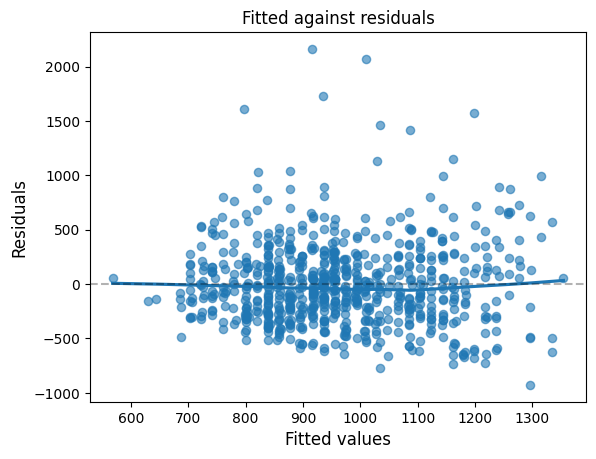

In [529]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 2 - Increased Number of Variables

In [530]:
model = smf.ols('wage ~ educ + exper + KWW + urban + married + IQ + black + tenure', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     29.21
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.26e-39
Time:                        22:19:01   Log-Likelihood:                -5337.2
No. Observations:                 733   AIC:                         1.069e+04
Df Residuals:                     724   BIC:                         1.073e+04
Df Model:                           8                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -683.0066    141.388     -4.831      0.000    -960.122    -405.891
educ          48.8057      8.333      5.857      0.000      32.474      65.138
exper         13.0178      3.588      3.628      0.000       5.985      20.051
KWW            5.2590      2.257      2.330      0.020       0.835       9.683
urban        157.2883     27.077      5.809      0.000     104.218     210.359
married      165.1190     38.213      4.321      0.000      90.224     240.014
IQ             3.5124      1.087      3.230      0.001       1.381       5.644
black       -124.6535     36.259     -3.438      0.001    -195.719     -53.588
tenure         6.5538      2.783      2.355      0.019       1.099      12.008
==============================================================================
Omnibus:                      214.829   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.979
Skew:                           1.332   Prob(JB):                    3.23e-179
Kurtosis:                       7.452   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [531]:
model.mse_resid**0.5

np.float64(353.7382125538841)

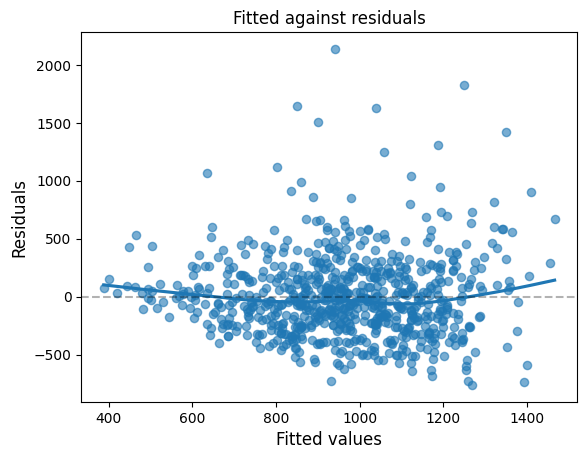

In [532]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [533]:
#Potential Interaction effects
educ_IQ = train['educ'] * train['IQ']
educ_KWW = train['educ'] * train['KWW'] #Significant
urban_married = train['urban'] * train['married']
exper_tenure = train['exper'] * train['tenure']
KWW_black = train['KWW'] * train['black']
tenure_married = train['tenure'] * train['married']
black_urban = train['black'] * train['urban']
exper_urban = train['exper'] * train['urban']
exper_black = train['exper'] * train['black']
IQ_urban = train['IQ'] * train['urban']
IQ_married = train['IQ'] * train['married']
IQ_exper = train['IQ'] * train['exper']
IQ_tenure = train['IQ'] * train['tenure']
black_married = train['black'] * train['married']
black_tenure = train['black'] * train['tenure'] #Significant
educ_urban = train['educ'] * train['urban']
educ_black = train['educ'] * train['black']

### Model 3 - Log Wage Base Model

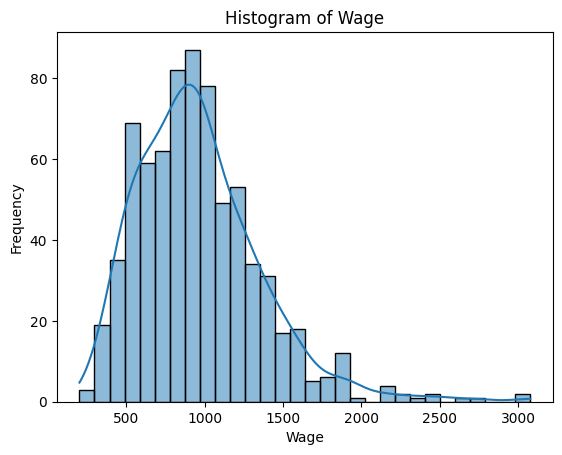

In [534]:
sns.histplot(train['wage'], bins=30, kde=True)
plt.title('Histogram of Wage')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.show()

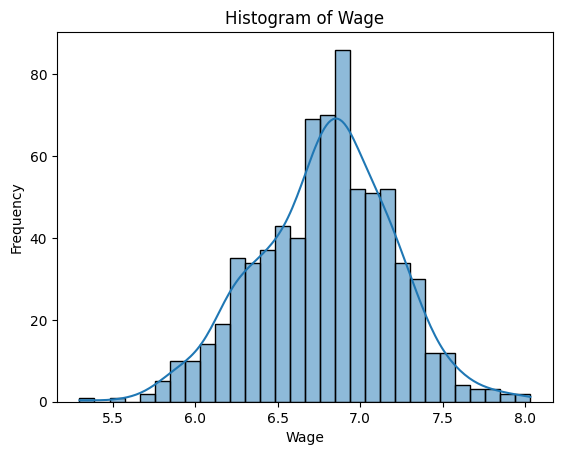

In [535]:
sns.histplot(train['lwage'], bins=30, kde=True)
plt.title('Histogram of Wage')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.show()

In [569]:
model = smf.ols('lwage ~ educ + exper', data=train).fit(cov_type = 'HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     51.00
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.86e-21
Time:                        22:30:31   Log-Likelihood:                -337.19
No. Observations:                 733   AIC:                             680.4
Df Residuals:                     730   BIC:                             694.2
Df Model:                           2                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4911      0.131     41.800      0.000       5.234       5.749
educ           0.0776      0.008     10.047      0.000       0.062       0.093
exper          0.0216      0.004      5.967      0.000       0.014       0.029
==============================================================================
Omnibus:                        8.335   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.508
Skew:                          -0.219   Prob(JB):                       0.0142
Kurtosis:                       3.296   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [570]:
model.mse_resid**0.5

np.float64(0.3840889633330187)

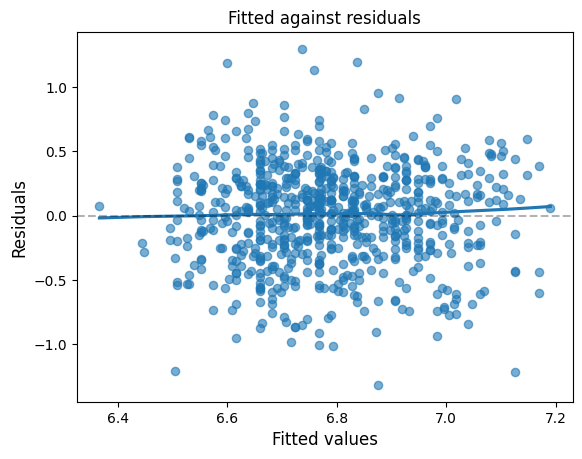

In [571]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 4 - Log Wage Increased Number of Variables

In [537]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [538]:
df = train[['lwage', 'educ', 'exper', 'hours', 'IQ', 'KWW', 'tenure', 'age', 'married', 'black', 'south', 'urban', 'sibs', 'meduc', 'feduc']]

In [539]:
model = forward_selected(df, 'lwage')

adding IQ increases adj_r2 from 0.000000 to 0.102645
adding tenure increases adj_r2 from 0.102645 to 0.136089
adding urban increases adj_r2 from 0.136089 to 0.171899
adding educ increases adj_r2 from 0.171899 to 0.198809
adding married increases adj_r2 from 0.198809 to 0.224029
adding exper increases adj_r2 from 0.224029 to 0.243531
adding black increases adj_r2 from 0.243531 to 0.257825
adding hours increases adj_r2 from 0.257825 to 0.265998
adding south increases adj_r2 from 0.265998 to 0.268653
adding KWW increases adj_r2 from 0.268653 to 0.271410
adding age increases adj_r2 from 0.271410 to 0.271692
final model is lwage ~ IQ + tenure + urban + educ + married + exper + black + hours + south + KWW + age + 1, with adj_r2 of 0.271692


In [540]:
model = smf.ols('lwage ~ IQ + tenure + urban + educ + married + exper + black + hours', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     38.44
Date:                Thu, 22 May 2025   Prob (F-statistic):           4.80e-51
Time:                        22:19:03   Log-Likelihood:                -272.10
No. Observations:                 733   AIC:                             562.2
Df Residuals:                     724   BIC:                             603.6
Df Model:                           8                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2949      0.171     31.038      0.000       4.961       5.629
IQ             0.0046      0.001      4.309      0.000       0.003       0.007
tenure         0.0112      0.003      4.011      0.000       0.006       0.017
urban          0.1835      0.029      6.434      0.000       0.128       0.239
educ           0.0537      0.008      6.450      0.000       0.037       0.070
married        0.2031      0.044      4.627      0.000       0.117       0.289
exper          0.0149      0.004      4.124      0.000       0.008       0.022
black         -0.1845      0.043     -4.260      0.000      -0.269      -0.100
hours         -0.0056      0.002     -2.497      0.013      -0.010      -0.001
==============================================================================
Omnibus:                        7.345   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               10.465
Skew:                           0.004   Prob(JB):                      0.00534
Kurtosis:                       3.585   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [541]:
model.mse_resid**0.5

np.float64(0.3529096367915573)

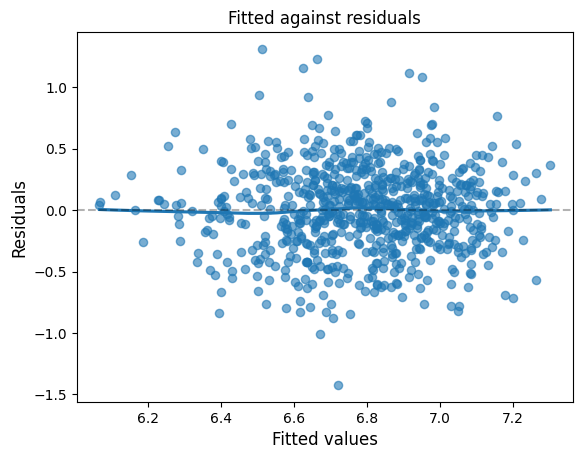

In [542]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 5 - Log Model with Interaction Effects

In [543]:
model = smf.ols('lwage ~ tenure + urban + educ + married + exper + black + hours + KWW + educ_KWW', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     32.71
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.50e-48
Time:                        22:19:03   Log-Likelihood:                -275.39
No. Observations:                 733   AIC:                             570.8
Df Residuals:                     723   BIC:                             616.8
Df Model:                           9                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3403      0.417     15.196      0.000       5.523       7.158
tenure         0.0106      0.003      3.726      0.000       0.005       0.016
urban          0.1838      0.029      6.310      0.000       0.127       0.241
educ          -0.0006      0.030     -0.020      0.984      -0.059       0.058
married        0.2041      0.044      4.659      0.000       0.118       0.290
exper          0.0124      0.004      3.319      0.001       0.005       0.020
black         -0.2304      0.046     -5.046      0.000      -0.320      -0.141
hours         -0.0059      0.002     -2.645      0.008      -0.010      -0.002
KWW           -0.0157      0.010     -1.513      0.130      -0.036       0.005
educ_KWW       0.0016      0.001      2.063      0.039    7.89e-05       0.003
==============================================================================
Omnibus:                        6.945   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.692
Skew:                          -0.016   Prob(JB):                      0.00786
Kurtosis:                       3.562   Cond. No.                     1.66e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [544]:
model.mse_resid**0.5

np.float64(0.3547421096922341)

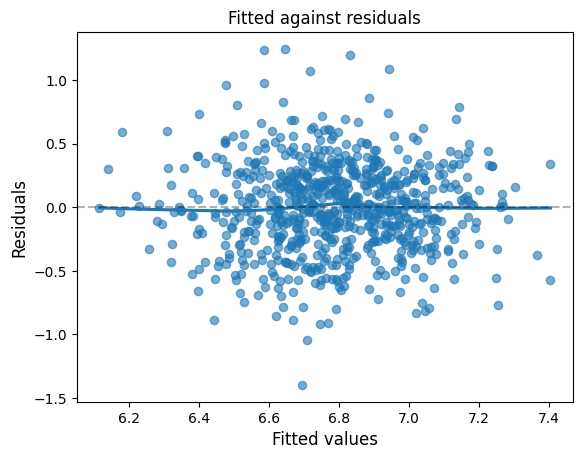

In [545]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 6 - Log Model with Interaction Effect

In [546]:
model = smf.ols('lwage ~ IQ + tenure + urban + educ + married + exper + black + hours + educ_black', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     34.39
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.37e-50
Time:                        22:19:04   Log-Likelihood:                -272.08
No. Observations:                 733   AIC:                             564.2
Df Residuals:                     723   BIC:                             610.1
Df Model:                           9                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2909      0.173     30.667      0.000       4.953       5.629
IQ             0.0046      0.001      4.303      0.000       0.003       0.007
tenure         0.0113      0.003      4.013      0.000       0.006       0.017
urban          0.1835      0.029      6.436      0.000       0.128       0.239
educ           0.0540      0.008      6.365      0.000       0.037       0.071
married        0.2033      0.044      4.633      0.000       0.117       0.289
exper          0.0149      0.004      4.096      0.000       0.008       0.022
black         -0.1208      0.266     -0.454      0.650      -0.642       0.400
hours         -0.0055      0.002     -2.484      0.013      -0.010      -0.001
educ_black    -0.0051      0.021     -0.240      0.810      -0.047       0.037
==============================================================================
Omnibus:                        7.359   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               10.491
Skew:                           0.005   Prob(JB):                      0.00527
Kurtosis:                       3.586   Cond. No.                     2.71e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 2.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [547]:
model.mse_resid**0.5

np.float64(0.3531429902964846)

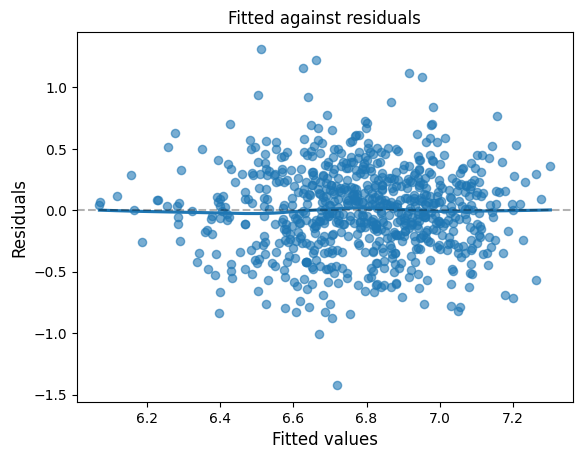

In [548]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 7 - Log Model with Spline KWW

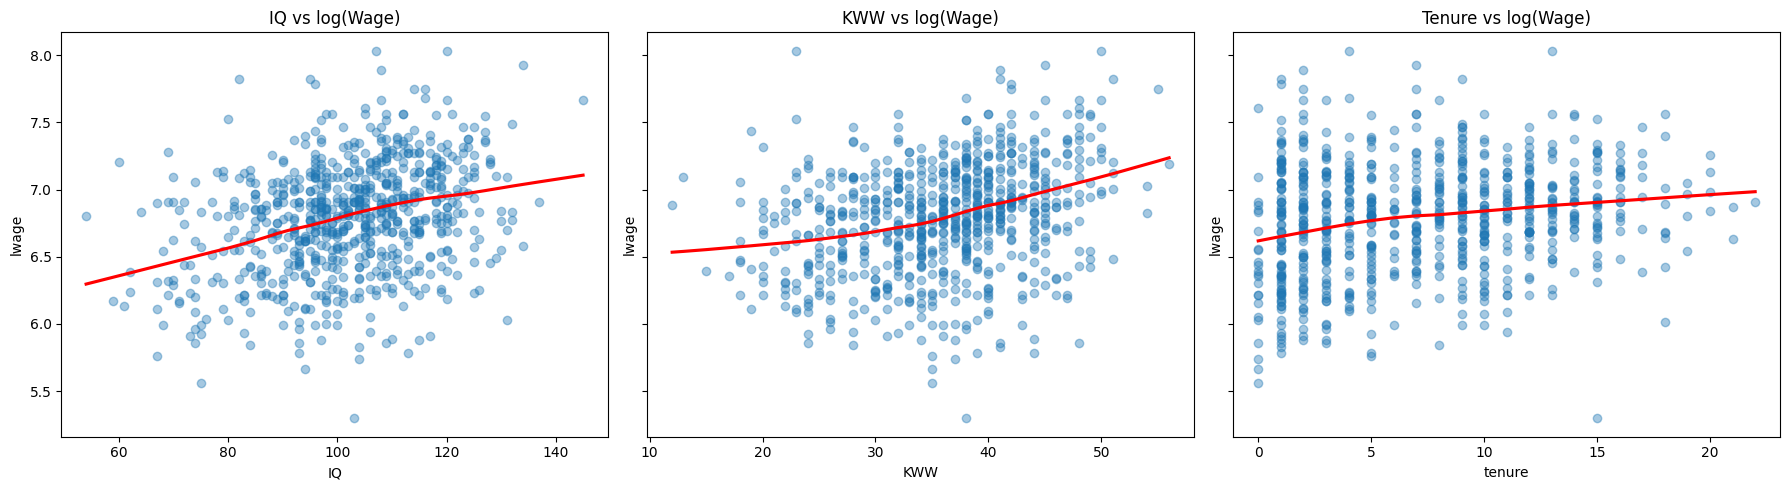

In [549]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# IQ vs lwage with LOWESS
sns.regplot(data=train, x='IQ', y='lwage', ax=axes[0], lowess=True,
            scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
axes[0].set_title('IQ vs log(Wage)')

# KWW vs lwage with LOWESS
sns.regplot(data=train, x='KWW', y='lwage', ax=axes[1], lowess=True,
            scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
axes[1].set_title('KWW vs log(Wage)')

# Tenure vs lwage with LOWESS
sns.regplot(data=train, x='tenure', y='lwage', ax=axes[2], lowess=True,
            scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
axes[2].set_title('Tenure vs log(Wage)')

# Layout adjustment
plt.tight_layout()
plt.show()

In [550]:
xi = 34

# Create the spline variable (positive part only)
train['KWW_step'] = (train['KWW'] > xi) * (train['KWW'] - xi)

In [551]:
model = smf.ols('lwage ~ IQ + tenure + urban + educ + married + exper + black + hours + KWW + KWW_step', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     33.14
Date:                Thu, 22 May 2025   Prob (F-statistic):           4.41e-53
Time:                        22:19:04   Log-Likelihood:                -265.37
No. Observations:                 733   AIC:                             552.7
Df Residuals:                     722   BIC:                             603.3
Df Model:                          10                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6399      0.196     28.805      0.000       5.256       6.024
IQ             0.0043      0.001      3.989      0.000       0.002       0.006
tenure         0.0100      0.003      3.511      0.000       0.004       0.016
urban          0.1773      0.028      6.284      0.000       0.122       0.233
educ           0.0462      0.009      5.301      0.000       0.029       0.063
married        0.2013      0.043      4.731      0.000       0.118       0.285
exper          0.0127      0.004      3.467      0.001       0.006       0.020
black         -0.1886      0.045     -4.168      0.000      -0.277      -0.100
hours         -0.0061      0.002     -2.806      0.005      -0.010      -0.002
KWW           -0.0063      0.004     -1.638      0.101      -0.014       0.001
KWW_step       0.0186      0.006      3.117      0.002       0.007       0.030
==============================================================================
Omnibus:                        7.042   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                9.580
Skew:                          -0.055   Prob(JB):                      0.00831
Kurtosis:                       3.549   Cond. No.                     1.78e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [552]:
model.mse_resid**0.5

np.float64(0.35016607066157124)

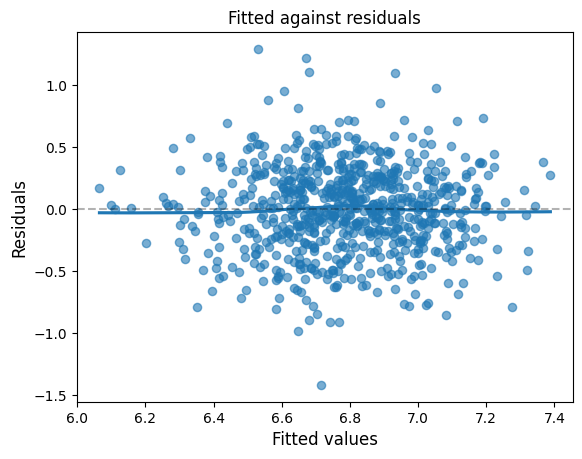

In [553]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 8 - Log Model with Spline IQ

In [554]:
xi = 105

# Create the spline term: positive part after the knot
train['IQ_step'] = (train['IQ'] > xi) * (train['IQ'] - xi)

In [555]:
model = smf.ols('lwage ~ IQ + IQ_step + tenure + urban + educ + married + exper + black + hours', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     34.72
Date:                Thu, 22 May 2025   Prob (F-statistic):           4.96e-51
Time:                        22:19:05   Log-Likelihood:                -272.08
No. Observations:                 733   AIC:                             564.2
Df Residuals:                     723   BIC:                             610.1
Df Model:                           9                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3162      0.189     28.076      0.000       4.945       5.687
IQ             0.0044      0.002      2.719      0.007       0.001       0.008
IQ_step        0.0006      0.003      0.192      0.848      -0.006       0.007
tenure         0.0113      0.003      4.019      0.000       0.006       0.017
urban          0.1836      0.029      6.427      0.000       0.128       0.240
educ           0.0535      0.008      6.496      0.000       0.037       0.070
married        0.2038      0.044      4.615      0.000       0.117       0.290
exper          0.0149      0.004      4.131      0.000       0.008       0.022
black         -0.1859      0.044     -4.264      0.000      -0.271      -0.100
hours         -0.0056      0.002     -2.493      0.013      -0.010      -0.001
==============================================================================
Omnibus:                        7.365   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.025   Jarque-Bera (JB):               10.502
Skew:                           0.005   Prob(JB):                      0.00524
Kurtosis:                       3.586   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [556]:
model.mse_resid**0.5

np.float64(0.35314479898937007)

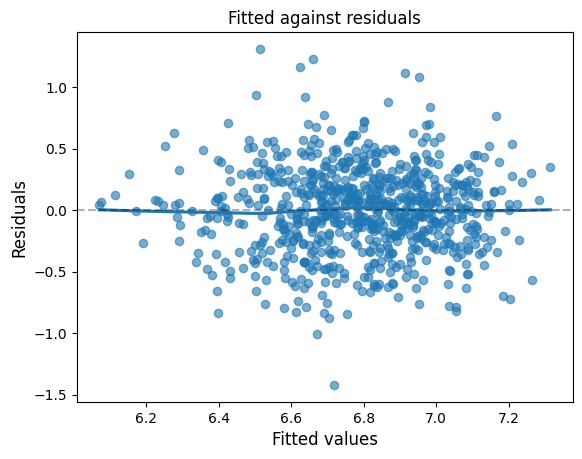

In [557]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 9 - Log Model with Spline Tenure

In [558]:
xi1 = 5

# Create piecewise linear spline terms
train['tenure_step'] = (train['tenure'] > xi1) * (train['tenure'] - xi1)

In [559]:
model = smf.ols('lwage ~ IQ + tenure + tenure_step + urban + educ + married + exper + black + hours', data=train).fit(cov_type = 'HC0')
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     34.69
Date:                Thu, 22 May 2025   Prob (F-statistic):           5.44e-51
Time:                        22:19:05   Log-Likelihood:                -270.80
No. Observations:                 733   AIC:                             561.6
Df Residuals:                     723   BIC:                             607.6
Df Model:                           9                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.2541      0.173     30.446      0.000       4.916       5.592
IQ              0.0047      0.001      4.360      0.000       0.003       0.007
tenure          0.0266      0.011      2.420      0.016       0.005       0.048
tenure_step    -0.0206      0.013     -1.535      0.125      -0.047       0.006
urban           0.1847      0.028      6.482      0.000       0.129       0.241
educ            0.0529      0.008      6.377      0.000       0.037       0.069
married         0.2022      0.044      4.641      0.000       0.117       0.288
exper           0.0153      0.004      4.216      0.000       0.008       0.022
black          -0.1832      0.043     -4.268      0.000      -0.267      -0.099
hours          -0.0056      0.002     -2.512      0.012      -0.010      -0.001
==============================================================================
Omnibus:                        7.873   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               11.338
Skew:                           0.034   Prob(JB):                      0.00345
Kurtosis:                       3.605   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [560]:
model.mse_resid**0.5

np.float64(0.35252778309686594)

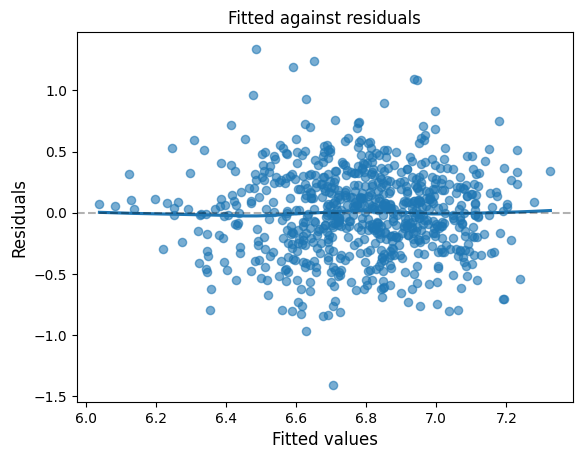

In [561]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Model 10 - Log Model with Splines

In [562]:
iq1 = train['IQ'].quantile(0.2)
iq2 = train['IQ'].quantile(0.4)
iq3 = train['IQ'].quantile(0.6)
iq4 = train['IQ'].quantile(0.8)

train['IQ_step1'] = (train['IQ'] > iq1) * (train['IQ'] - iq1)
train['IQ_step2'] = (train['IQ'] > iq2) * (train['IQ'] - iq2)
train['IQ_step3'] = (train['IQ'] > iq3) * (train['IQ'] - iq3)
train['IQ_step4'] = (train['IQ'] > iq4) * (train['IQ'] - iq4)

kww1 = train['KWW'].quantile(0.2)
kww2 = train['KWW'].quantile(0.4)
kww3 = train['KWW'].quantile(0.6)
kww4 = train['KWW'].quantile(0.8)

train['KWW_step1'] = (train['KWW'] > kww1) * (train['KWW'] - kww1)
train['KWW_step2'] = (train['KWW'] > kww2) * (train['KWW'] - kww2)
train['KWW_step3'] = (train['KWW'] > kww3) * (train['KWW'] - kww3)
train['KWW_step4'] = (train['KWW'] > kww4) * (train['KWW'] - kww4)

t1 = train['tenure'].quantile(0.2)
t2 = train['tenure'].quantile(0.4)
t3 = train['tenure'].quantile(0.6)
t4 = train['tenure'].quantile(0.8)

# Create piecewise spline terms
train['tenure_step1'] = (train['tenure'] > t1) * (train['tenure'] - t1)
train['tenure_step2'] = (train['tenure'] > t2) * (train['tenure'] - t2)
train['tenure_step3'] = (train['tenure'] > t3) * (train['tenure'] - t3)
train['tenure_step4'] = (train['tenure'] > t4) * (train['tenure'] - t4)

In [563]:
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [564]:
df = train[['lwage', 'educ', 'exper', 'KWW_step1', 'KWW_step2', 'KWW_step3', 'KWW_step4', "IQ_step1", 'IQ_step2', 'IQ_step3', 'IQ_step4', 'tenure_step1', 'tenure_step2', 'tenure_step3', 'tenure_step4', 'hours', 'IQ', 'KWW', 'tenure', 'age', 'married', 'black', 'south', 'urban', 'sibs', 'meduc', 'feduc']]

In [565]:
model = forward_selected(df, 'lwage')

adding IQ increases adj_r2 from 0.000000 to 0.102645
adding KWW_step2 increases adj_r2 from 0.102645 to 0.149328
adding urban increases adj_r2 from 0.149328 to 0.177351
adding tenure increases adj_r2 from 0.177351 to 0.201693
adding married increases adj_r2 from 0.201693 to 0.220959
adding educ increases adj_r2 from 0.220959 to 0.239612
adding black increases adj_r2 from 0.239612 to 0.253003
adding exper increases adj_r2 from 0.253003 to 0.265600
adding hours increases adj_r2 from 0.265600 to 0.275576
adding tenure_step1 increases adj_r2 from 0.275576 to 0.282216
adding south increases adj_r2 from 0.282216 to 0.285259
adding KWW increases adj_r2 from 0.285259 to 0.286713
adding KWW_step4 increases adj_r2 from 0.286713 to 0.287169
final model is lwage ~ IQ + KWW_step2 + urban + tenure + married + educ + black + exper + hours + tenure_step1 + south + KWW + KWW_step4 + 1, with adj_r2 of 0.287169


In [566]:
model = smf.ols('lwage ~ IQ + KWW + KWW_step2 + urban + tenure + tenure_step1 + married + educ + black + exper + hours + south + black_tenure', data=train).fit(cov_type='HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     26.40
Date:                Thu, 22 May 2025   Prob (F-statistic):           1.01e-52
Time:                        22:19:09   Log-Likelihood:                -256.93
No. Observations:                 733   AIC:                             541.9
Df Residuals:                     719   BIC:                             606.2
Df Model:                          13                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.6308      0.208     27.038      0.000       5.223       6.039
IQ               0.0039      0.001      3.554      0.000       0.002       0.006
KWW             -0.0061      0.004     -1.583      0.113      -0.014       0.001
KWW_step2        0.0199      0.006      3.333      0.001       0.008       0.032
urban            0.1736      0.028      6.157      0.000       0.118       0.229
tenure           0.0845      0.036      2.362      0.018       0.014       0.155
tenure_step1    -0.0806      0.037     -2.192      0.028      -0.153      -0.009
married          0.1861      0.041      4.509      0.000       0.105       0.267
educ             0.0440      0.009      5.135      0.000       0.027       0.061
black           -0.2909      0.077     -3.802      0.000      -0.441      -0.141
exper            0.0125      0.004      3.458      0.001       0.005       0.020
hours           -0.0061      0.002     -2.810      0.005      -0.010      -0.002
south           -0.0574      0.030     -1.902      0.057      -0.117       0.002
black_tenure     0.0197      0.008      2.540      0.011       0.004       0.035
==============================================================================
Omnibus:                        6.382   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                8.696
Skew:                           0.006   Prob(JB):                       0.0129
Kurtosis:                       3.533   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [567]:
model.mse_resid**0.5

np.float64(0.34688043078667785)

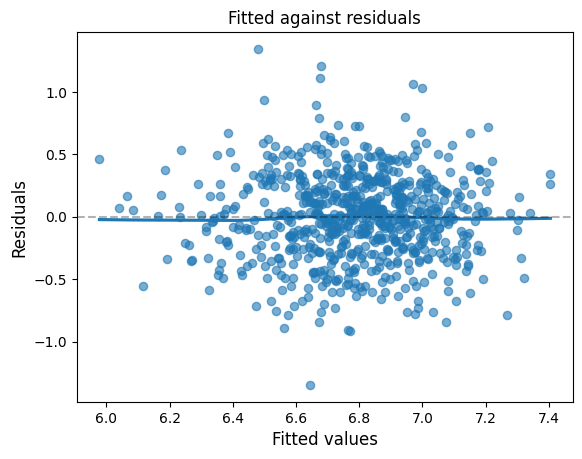

In [568]:
resid = model.resid
fitted = model.fittedvalues
fig, ax= plt.subplots()
sns.regplot(x=fitted, y=resid, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('Fitted values',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Fitted against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Summary


| Model              | SER    | R-squared adj. | Good fit? | No. Predictors |
|--------------------|--------|----------------|-----------|----------------|
| linear - base      | 375.51 | 0.130          | Yes       | 2              |
| linear + vars      | 353.74 | 0.228          | No        | 8              |
| log - linear       | 0.3841 | 0.131          | No        | 2              |
| log + vars         | 0.3529 | 0.266          | Yes       | 8              |
| log-linear - IE1   | 0.3547 | 0.258          | Yes       | 9              |
| log-linear - IE2   | 0.3531 | 0.265          | Yes       | 9              |
| linear spline - KWW| 0.3502 | 0.277          | Yes       | 10             |
| linear spline - IQ | 0.3531 | 0.265          | Yes       | 9              |
| linear spline - Ten| 0.3525 | 0.268          | Yes       | 9              |
| linear splines quan| 0.3468 | 0.291          | Yes       | 13             |
